In [1]:
# include libraries
import sys
sys.path.append('./libs')
import torch
import libs.setup as su
import importlib


# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


## Data Preparation

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from libs.dataset import FireRiskDataset

# Define the transformations for training data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),  # VIT requires 224 input
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(2, 0.9),
        transforms.RandomVerticalFlip(),
        transforms.Normalize(mean=[0.332, 0.422, 0.402], std=[0.064, 0.084, 0.093]),
    ]
)

# Define the transformations for validation data
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),  # VIT requires 224 input
        transforms.Normalize(mean=[0.332, 0.422, 0.402], std=[0.064, 0.084, 0.093]),
    ]
)

# Define the classes and label dictionary
classes = ["High", "Moderate", "Low", "Non-burnable", "Water"]
label_dict = {
    "High": 0,
    "Moderate": 1,
    "Low": 2,
    "Non-burnable": 3,
    "Water": 4,
}

# Setup training dataset and loader
train_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/train/",
    transform=transform,
    sample_size=su.train_samples,
    label_dict=label_dict,

)

# Setup training dataset and loader
train_loader = DataLoader(

    dataset=train_dataset,
    batch_size=su.batch_size,
    shuffle=True,
    num_workers=su.num_workers,

)

# Setup validation dataset and loader
val_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/val/",
    transform=val_transform,
    sample_size=su.sample_size,
    label_dict=label_dict,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=su.batch_size,
    shuffle=False,
    num_workers=su.num_workers,
)

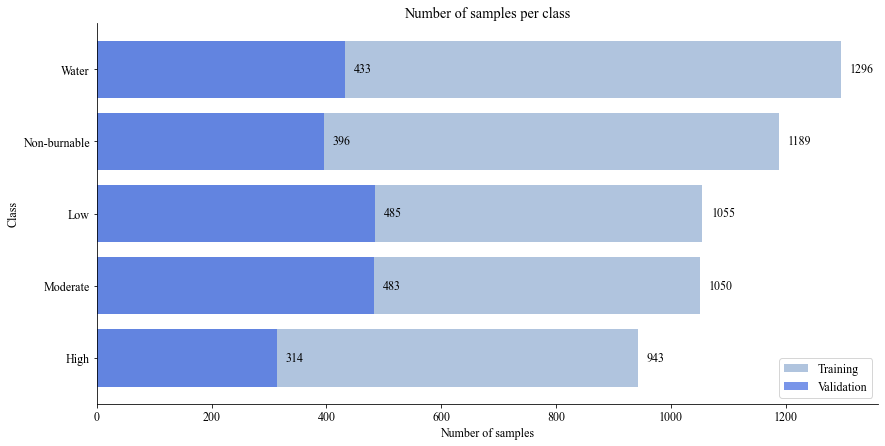

Training dataset size: 5533
Validations dataset size: 2111


<Figure size 432x288 with 0 Axes>

In [3]:
# Plot a graph with the number of samples per class
import matplotlib.pyplot as plt

# Set global font to Arial
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12  # You can also set the global font size here

plt.figure(figsize=(14, 7))

# Plot training data
train_counts = [train_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, train_counts, label="Training", color="lightsteelblue")

# Plot validation data
val_counts = [val_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, val_counts, label="Validation", alpha=0.7, color="royalblue")

# Labels and title
plt.xlabel("Number of samples")
plt.ylabel("Class")
plt.title("Number of samples per class")
plt.legend()

# Font sizes for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add total number of samples after the bar
margin = 15
for index, value in enumerate(train_counts):
    plt.text(
        value + margin,
        index,
        str(value),
        va="center",
        ha="left",
        fontsize=12,
        color="black",
    )
for index, value in enumerate(val_counts):
    plt.text(
        value + margin,
        index,
        str(value),
        va="center",
        ha="left",
        fontsize=12,
        color="black",
    )

plt.show()

plt.savefig("prometheus_dataset.png", dpi=300)

# Print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Validations dataset size:", len(val_dataset))

In [4]:
import timm

class ViT_B_16_UnlabeledNAIP (torch.nn.Module):
    def __init__(self, num_classes, checkpoint_path):
        super().__init__()
        # Initialize the ViT-B/16 without pretrained weights since we are loading from a checkpoint
        self.mae = timm.create_model("vit_base_patch16_224", pretrained=False)

        # Load the checkpoint
        self.load_checkpoint(checkpoint_path)

        # After loading the checkpoint, the feature dimension can be determined by the model's head
        if hasattr(self.mae, 'head'):
            feature_dim = self.mae.head.in_features
        else:
            # Default to 768 if the model's head isn't already set, typical for ViT-B
            feature_dim = 768

        # Replace the classification head with one suited for your number of classes
        self.mae.head = torch.nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.mae(x)

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        try:
            self.mae.load_state_dict(checkpoint["model"], strict=False)
            print("Loaded the model state dictionary successfully.")
        except RuntimeError as e:
            print("Error loading the model state dictionary:", e)

vitb16_model = ViT_B_16_UnlabeledNAIP(
    num_classes=5, checkpoint_path="./models/MAE_Pretrained/MAE.pth"
)

Loaded the model state dictionary successfully.


In [5]:
# Freeze patch embedding, initial drop and the first 3 transformer blocks
for name, param in vitb16_model.named_parameters():
    if (
        "patch_embed" in name
        # or "pos_drop" in name
        or "blocks.0" in name
        or "blocks.1" in name
        or "blocks.2" in name
    ):
        param.requires_grad = False

In [6]:
# Weights for each class based on their difficulty or importance
# class_weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0], dtype=torch.float32)
# if torch.cuda.is_available():
#     class_weights = class_weights.cuda()

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=su.smoothing_factor).to(device)
optimizer = torch.optim.SGD(
    vitb16_model.parameters(), lr=su.learning_rate, weight_decay=su.weight_decay
)

In [7]:
import libs.model_utils as mu

if __name__ == "__main__":

    # Build our model
    (
        best_loss,
        best_accuracy,
        best_epoch,
        train_acc_list,
        train_loss_list,
        val_acc_list,
        val_loss_list,
    ) = mu.train_and_eval(
        model=vitb16_model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        start_epoch=0,
        num_epochs=su.num_epochs,
        early_stop=True,
        patience=su.patience,
        path_model=str("./models/ViT_B_16/Prometheus_ViT_B_16_"),
        verbatim=True,
    )
    print('Finished Training')

Epoch [1 / 80]: Train Loss=1.5379001598137652, Train Accu=0.40062249888839485, Validation Loss=1.3618820544445154, Validation Accu=0.5149936868686869
Validation loss decreased (inf --> 1.361882).  Saving model ...
Epoch [2 / 80]: Train Loss=1.3327013309291333, Train Accu=0.5174522009782125, Validation Loss=1.2593867376898273, Validation Accu=0.5770202020202021
Validation loss decreased (1.361882 --> 1.259387).  Saving model ...
Epoch [3 / 80]: Train Loss=1.268177693634364, Train Accu=0.5537183192530013, Validation Loss=1.20985080798467, Validation Accu=0.5926767676767677
Validation loss decreased (1.259387 --> 1.209851).  Saving model ...
Epoch [4 / 80]: Train Loss=1.230490830936873, Train Accu=0.5758392618941752, Validation Loss=1.1754862571304494, Validation Accu=0.6182449494949495
Validation loss decreased (1.209851 --> 1.175486).  Saving model ...
Epoch [5 / 80]: Train Loss=1.2021443154770515, Train Accu=0.5950700311249444, Validation Loss=1.153177050930081, Validation Accu=0.61587

Best loss: 0.9735754563501386
Best accuracy: 0.7030618686868686
Best epoch: 80


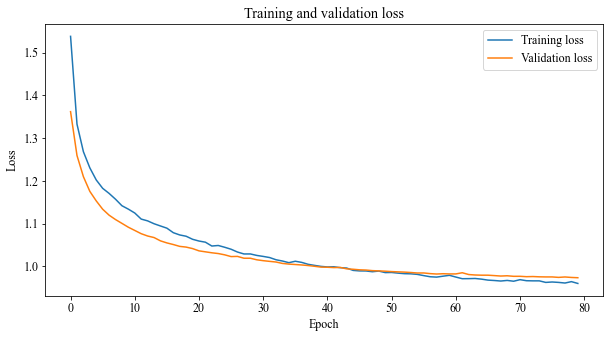

In [8]:
# Display the best results
print("Best loss:", best_loss)
print("Best accuracy:", best_accuracy)
print("Best epoch:", best_epoch+1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training loss")
plt.plot(val_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
# Load the best model
import libs.model_utils as mu

# Load the model we just created
vitb16_model = vitb16_model.to(device)

# Get best model path
best_model_path = (
    "./models/ViT_B_16/Prometheus_ViT_B_16_checkpoint.pth"
)

vitb16_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [10]:
true_labels, predicted_labels = mu.evaluate_model(
    vitb16_model, val_loader, device, loss_fn
)

Accuracy on validation set: 70.29843675982947%


In [11]:
# Implement precision, recall and F1-score assessment
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=classes)

# Print the classification report
print(report)

              precision    recall  f1-score   support

        High       0.64      0.59      0.62       314
    Moderate       0.59      0.64      0.62       483
         Low       0.74      0.69      0.71       485
Non-burnable       0.66      0.76      0.70       396
       Water       0.91      0.82      0.86       433

    accuracy                           0.70      2111
   macro avg       0.71      0.70      0.70      2111
weighted avg       0.71      0.70      0.71      2111



Predicted class: Moderate
File name: 31259471_3_-120.242973348723_41.5479914724108.png


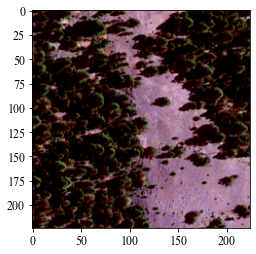

In [23]:
mu.predict_image_class(
    class_name="Moderate",
    dataset=val_dataset,
    model=vitb16_model,
    device=device,
    transform=transform,
    classes=classes,
)

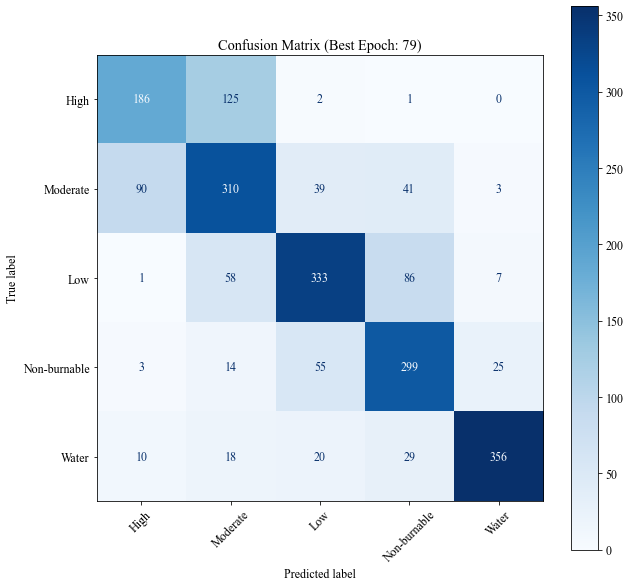

In [12]:
from importlib import reload
import libs.model_utils as mu
reload(mu)
mu.plot_confusion_matrix(true_labels, predicted_labels, classes, best_epoch)